In [19]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd

# -----------------------------
# FDSN client (EarthScope / IRIS)
# -----------------------------
client = Client("IRIS")

# -----------------------------
# Appalachian region bounding box
# (conservative, adjustable)
# -----------------------------
minlatitude = 32.0
maxlatitude = 42.5
minlongitude = -90.0
maxlongitude = -74.0

# -----------------------------
# Time window (broad query)
# -----------------------------
t_start = UTCDateTime("1990-01-01")
t_end   = UTCDateTime()

# -----------------------------
# Query stations with BH channels
# -----------------------------
inventory = client.get_stations(
    minlatitude=minlatitude,
    maxlatitude=maxlatitude,
    minlongitude=minlongitude,
    maxlongitude=maxlongitude,
    channel="BH?",
    starttime=t_start,
    endtime=t_end,
    level="channel"
)

# -----------------------------
# Minimum duration threshold
# -----------------------------
min_years = 2.0
#min_years = 1.5
min_seconds = min_years * 365.25 * 24 * 3600

records = []

# -----------------------------
# Parse inventory
# -----------------------------
for network in inventory:
    for station in network:
        bh_channels = [ch for ch in station.channels if ch.code.startswith("BH")]

        if len(bh_channels) < 3:
            continue  # Require full BH* set

        # Determine data span across BH channels
        start_times = []
        end_times = []

        for ch in bh_channels:
            if ch.start_date:
                start_times.append(ch.start_date)
            if ch.end_date:
                end_times.append(ch.end_date)
            else:
                end_times.append(t_end)

        if not start_times or not end_times:
            continue

        span = min(end_times) - max(start_times)

        if span >= min_seconds:
            records.append({
                "network": network.code,
                "station": station.code,
                "latitude": station.latitude,
                "longitude": station.longitude,
                "elevation_m": station.elevation,
                "start_date": max(start_times).date,
                "end_date": min(end_times).date,
                "duration_years": span / (365.25 * 24 * 3600)
            })

# -----------------------------
# Convert to DataFrame
# -----------------------------
df = pd.DataFrame(records).sort_values(
    by="duration_years", ascending=False
)

# -----------------------------
# Output
# -----------------------------
print(f"\nStations with BH* channels ≥ {min_years} years:\n")
print(df.to_string(index=False))

# Optional: save to CSV
df.to_csv("appalachian_BH_stations_2yr_plus.csv", index=False)



Stations with BH* channels ≥ 2.0 years:

network station  latitude  longitude  elevation_m start_date   end_date  duration_years
     PN   PNNAF 38.333000 -85.931000         22.9 1999-01-01 2026-01-09       27.025193
     PN   PPHHS 37.972000 -87.486000        122.2 1999-01-01 2026-01-09       27.025193
     PN   PPMUN 40.201000 -85.387001        280.0 1999-01-01 2026-01-09       27.025193
     PN    PURD 40.438000 -86.946198        207.0 1999-01-10 2026-01-09       27.000552
     SS    NCAT 36.078957 -79.771179        243.0 2009-02-03 2026-01-09       16.933475
     LD    WUPA 39.932417 -75.605983         86.0 2014-07-01 2026-01-09       11.528957
     PE    WRPS 40.794180 -77.865320        320.0 2005-04-06 2016-01-11       10.766133
     PE    PAGS 40.227700 -76.722200        120.0 2009-02-12 2019-06-06       10.310098
     NM    CGM3 37.297750 -89.658200        148.0 2015-10-02 2026-01-09       10.272569
     LD     MVL 39.999395 -76.348888        106.0 2001-02-12 2011-03-16       

plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +S<size> is used. Option -l ignored.
legend [WARNING]: File <stdin> is empty!


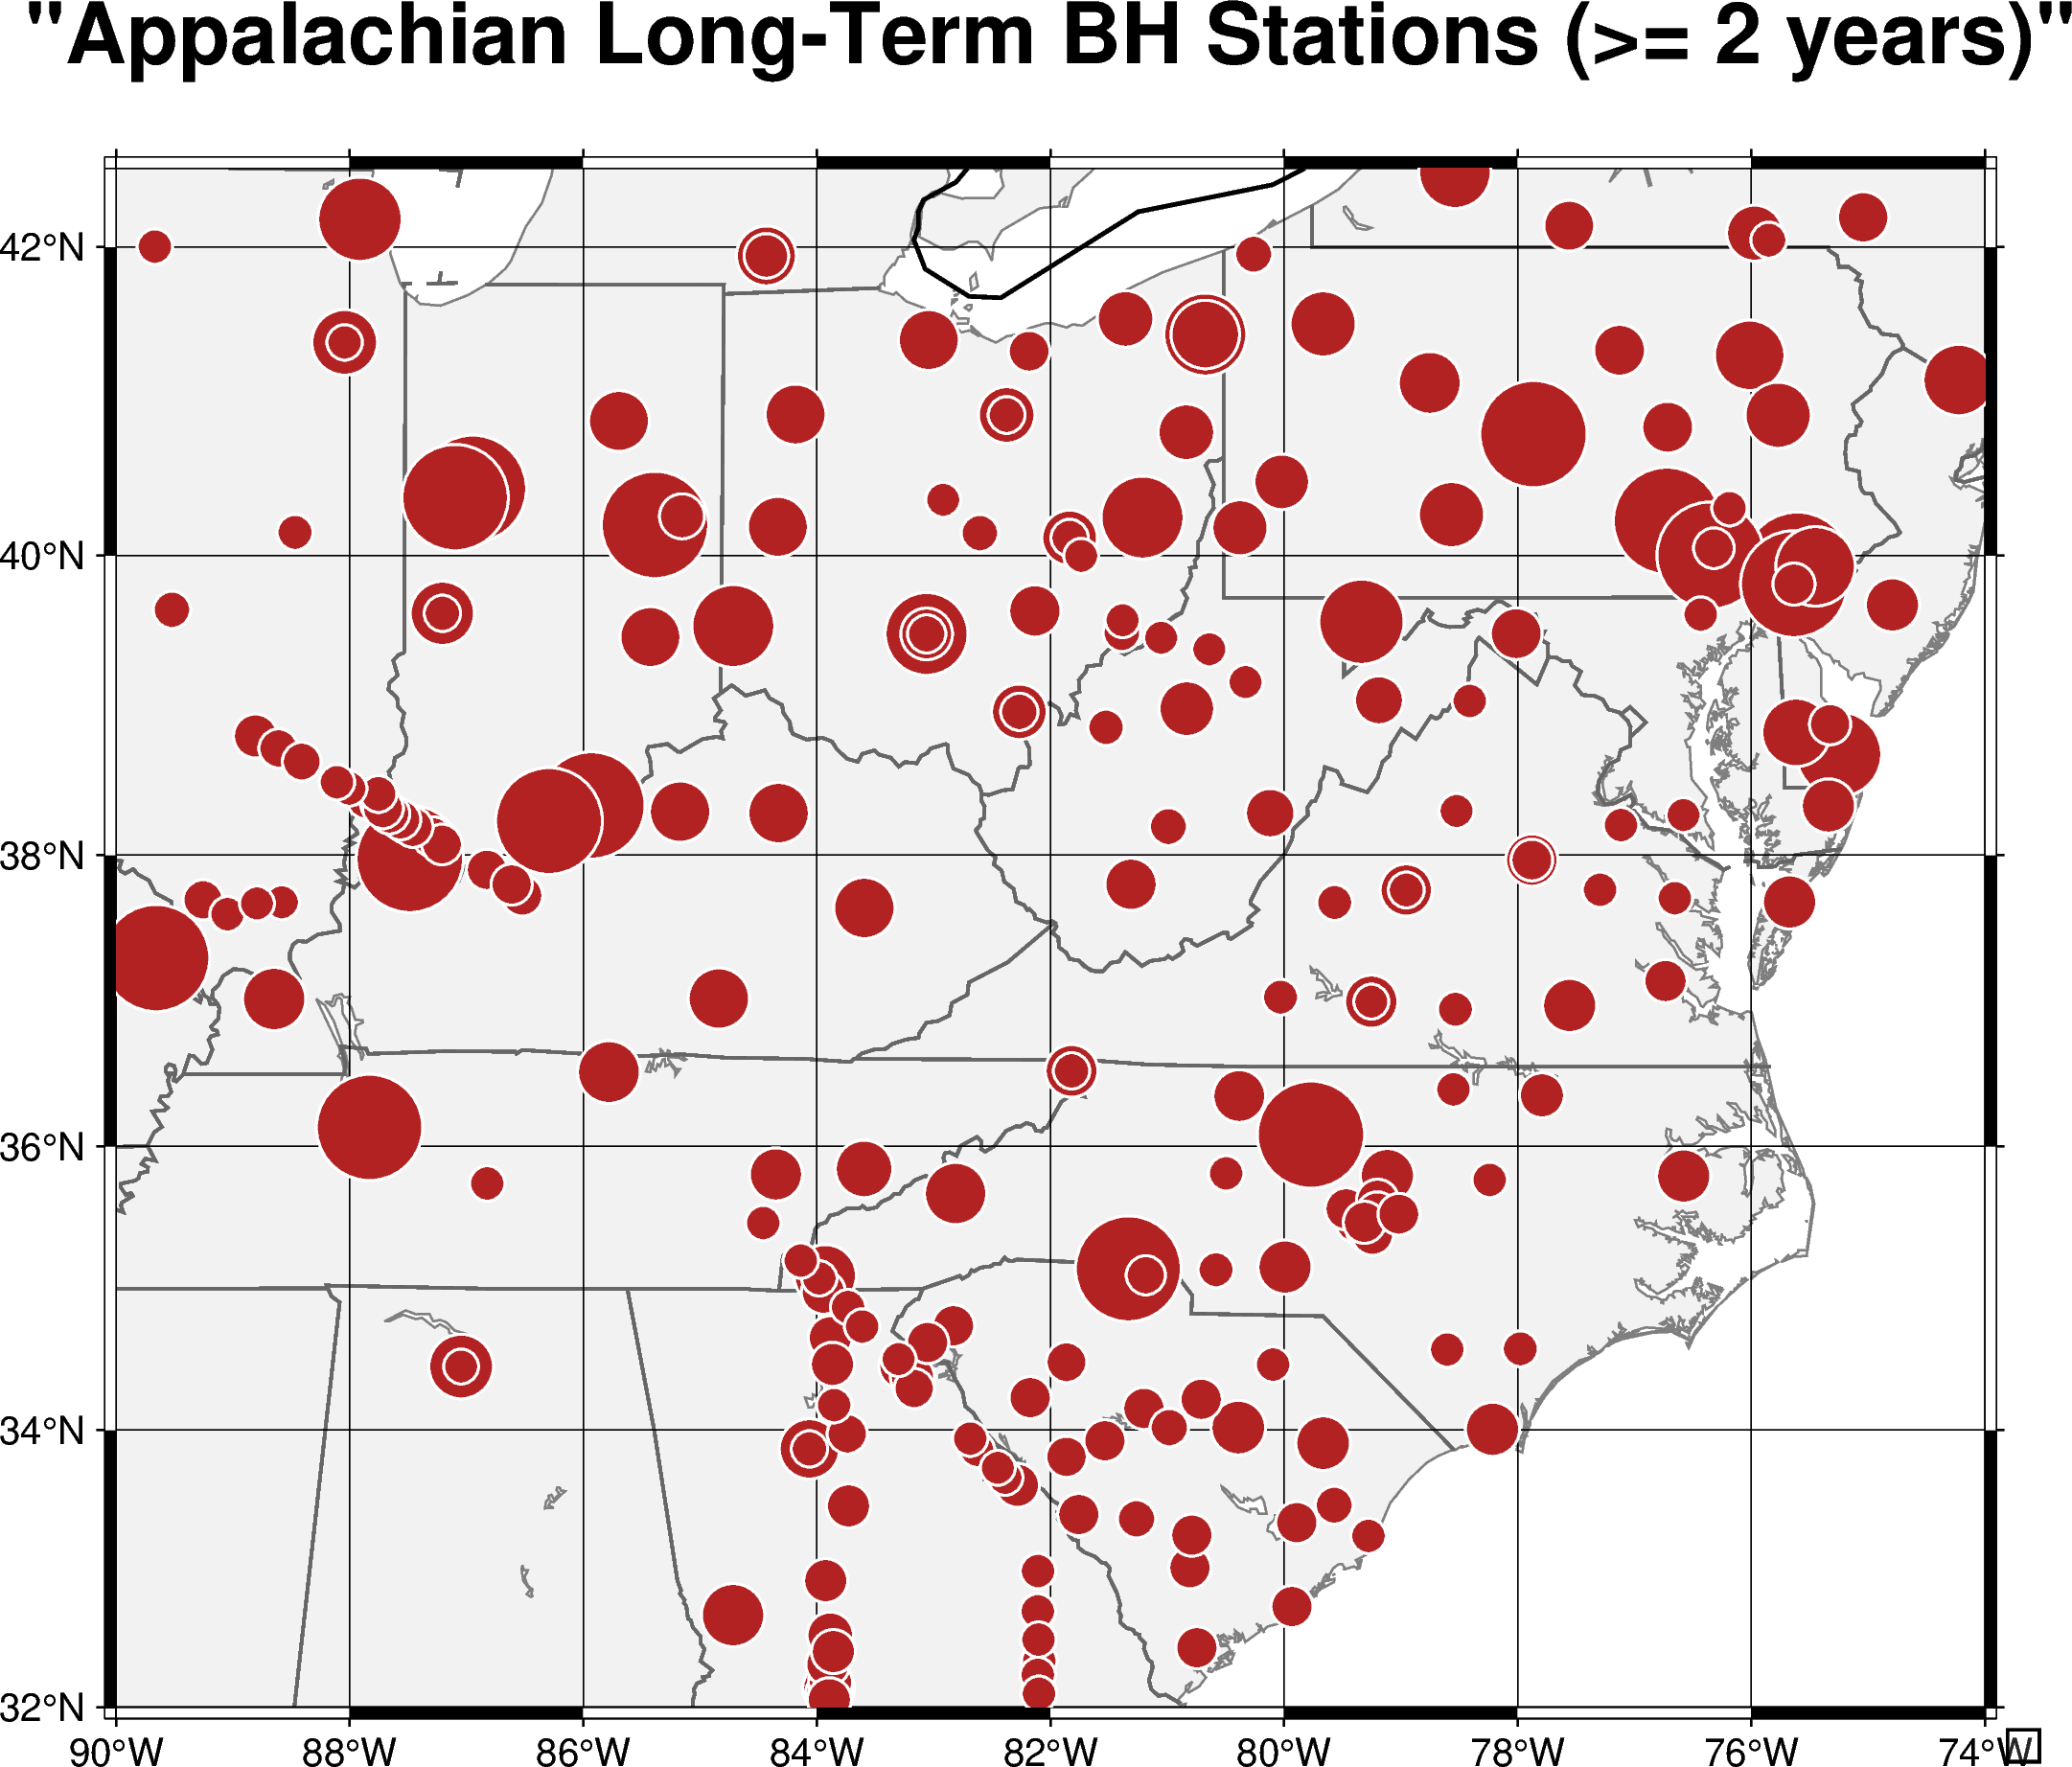

In [20]:
import pygmt
import pandas as pd

# -----------------------------
# Input station CSV
# -----------------------------
station_file = "appalachian_BH_stations_2yr_plus.csv"
df = pd.read_csv(station_file)

# -----------------------------
# Appalachian region
# -----------------------------
region = [-90.0, -74.0, 32, 42.5]
projection = "M6.5i"

# -----------------------------
# Create figure
# -----------------------------
fig = pygmt.Figure()

# -----------------------------
# Basemap
# -----------------------------
fig.coast(
    region=region,
    projection=projection,
    land="gray95",
    water="white",
    borders=[
        "1/1p,black",
        "2/0.8p,gray40"
    ],
    shorelines="0.5p,gray50",
    frame=["ag", 'WSne+t"Appalachian Long-Term BH Stations (>= 2 years)"']
)

# -----------------------------
# Symbol size scaled by duration
# -----------------------------
sizes = df["duration_years"].clip(upper=10) * 0.08 + 0.15

# -----------------------------
# Plot stations (WITH legend label)
# -----------------------------
fig.plot(
    x=df["longitude"],
    y=df["latitude"],
    style="c",
    size=sizes,
    fill="firebrick",
    pen="0.6p,white",
    label="BH* station (>= 2 years)"
)

# -----------------------------
# Auto legend (SAFE & CORRECT)
# -----------------------------
fig.legend(
    position="JBR+o0.2c",
    box="+gwhite@85+p0.8p"
)

# -----------------------------
# Save output
# -----------------------------
fig.savefig("appalachian_longterm_BH_stations.png", dpi=300)
fig.show()


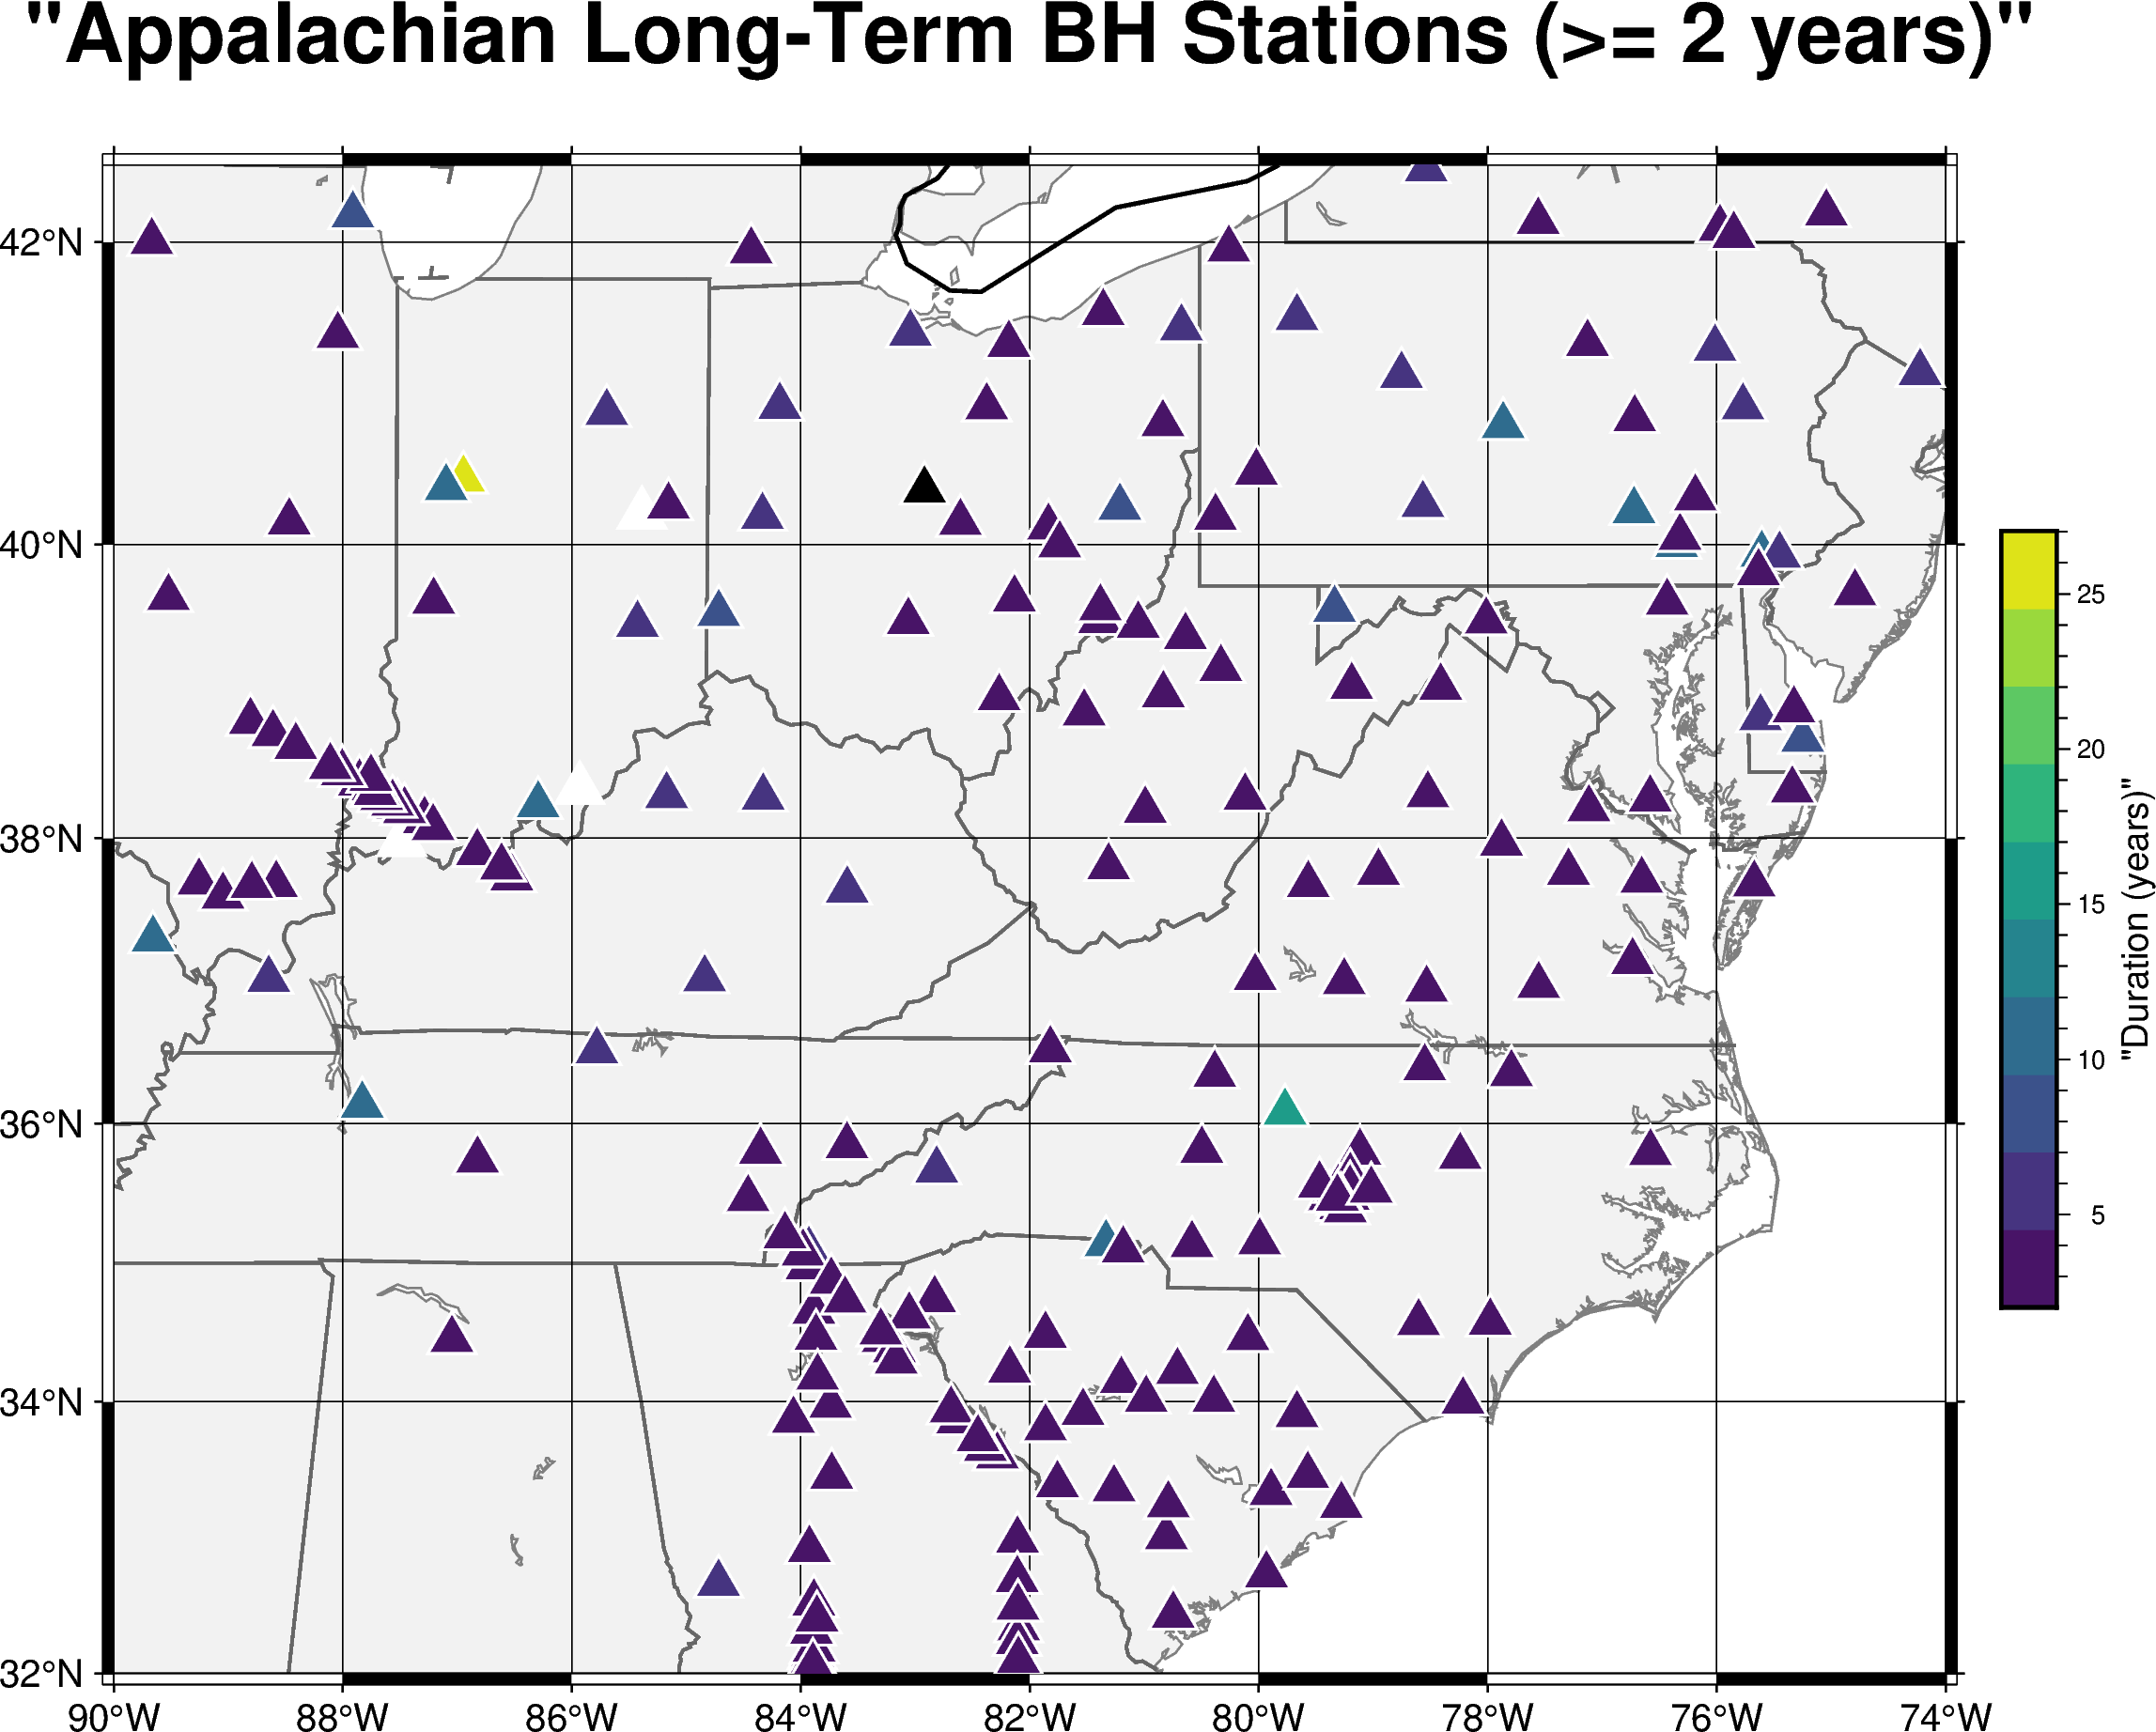

In [21]:
import pygmt
import pandas as pd

# -----------------------------
# Input station CSV
# -----------------------------
station_file = "appalachian_BH_stations_2yr_plus.csv"
df = pd.read_csv(station_file)

# -----------------------------
# Appalachian region
# -----------------------------
region = [-90.0, -74.0, 32, 42.5]
projection = "M6.5i"

# -----------------------------
# Create figure
# -----------------------------
fig = pygmt.Figure()

# -----------------------------
# Basemap
# -----------------------------
fig.coast(
    region=region,
    projection=projection,
    land="gray95",
    water="white",
    borders=[
        "1/1p,black",
        "2/0.8p,gray40"
    ],
    shorelines="0.5p,gray50",
    frame=["ag", 'WSne+t"Appalachian Long-Term BH Stations (>= 2 years)"']
)

# -----------------------------
# Symbol size (fixed for clarity)
# -----------------------------
sizes = 0.5  # fixed size in cm

# -----------------------------
# Create CPT (colormap) for duration
# -----------------------------
vmin = df["duration_years"].min()
vmax = df["duration_years"].max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax, (vmax-vmin)/10])

# -----------------------------
# Plot stations as triangles with color = duration
# -----------------------------
fig.plot(
    x=df["longitude"],
    y=df["latitude"],
    style=f"t{sizes}c",
    fill=df["duration_years"],
    cmap=True,       # use the CPT we just created
    pen="0.6p,white"
)

# -----------------------------
# Add colorbar
# -----------------------------
fig.colorbar(frame='af+l"Duration (years)"', position="JMR+o0.5c/0c+w7c/0.5c")

# -----------------------------
# Save output
# -----------------------------
fig.savefig("appalachian_longterm_BH_stations_triangles_colored.png", dpi=300)
fig.show()


In [22]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd

# -----------------------------
# FDSN client (EarthScope / IRIS)
# -----------------------------
client = Client("IRIS")

# -----------------------------
# Appalachian region bounding box
# (conservative, adjustable)
# -----------------------------
minlatitude = 32.0
maxlatitude = 42.5
minlongitude = -90.0
maxlongitude = -74.0

# -----------------------------
# Time window (broad query)
# -----------------------------
t_start = UTCDateTime("1990-01-01")
t_end   = UTCDateTime()

# -----------------------------
# Query stations with BH channels
# -----------------------------
inventory = client.get_stations(
    minlatitude=minlatitude,
    maxlatitude=maxlatitude,
    minlongitude=minlongitude,
    maxlongitude=maxlongitude,
    channel="BH?",
    starttime=t_start,
    endtime=t_end,
    level="channel"
)

# -----------------------------
# Minimum duration threshold
# -----------------------------
#min_years = 2.0
min_years = 1.5
min_seconds = min_years * 365.25 * 24 * 3600

records = []

# -----------------------------
# Parse inventory
# -----------------------------
for network in inventory:
    for station in network:
        bh_channels = [ch for ch in station.channels if ch.code.startswith("BH")]

        if len(bh_channels) < 3:
            continue  # Require full BH* set

        # Determine data span across BH channels
        start_times = []
        end_times = []

        for ch in bh_channels:
            if ch.start_date:
                start_times.append(ch.start_date)
            if ch.end_date:
                end_times.append(ch.end_date)
            else:
                end_times.append(t_end)

        if not start_times or not end_times:
            continue

        span = min(end_times) - max(start_times)

        if span >= min_seconds:
            records.append({
                "network": network.code,
                "station": station.code,
                "latitude": station.latitude,
                "longitude": station.longitude,
                "elevation_m": station.elevation,
                "start_date": max(start_times).date,
                "end_date": min(end_times).date,
                "duration_years": span / (365.25 * 24 * 3600)
            })

# -----------------------------
# Convert to DataFrame
# -----------------------------
df = pd.DataFrame(records).sort_values(
    by="duration_years", ascending=False
)

# -----------------------------
# Output
# -----------------------------
print(f"\nStations with BH* channels ≥ {min_years} years:\n")
print(df.to_string(index=False))

# Optional: save to CSV
df.to_csv("appalachian_BH_stations_1.5yr_plus.csv", index=False)



Stations with BH* channels ≥ 1.5 years:

network station  latitude  longitude  elevation_m start_date   end_date  duration_years
     PN   PPHHS 37.972000 -87.486000        122.2 1999-01-01 2026-01-09       27.025194
     PN   PPMUN 40.201000 -85.387001        280.0 1999-01-01 2026-01-09       27.025194
     PN   PNNAF 38.333000 -85.931000         22.9 1999-01-01 2026-01-09       27.025194
     PN    PURD 40.438000 -86.946198        207.0 1999-01-10 2026-01-09       27.000553
     SS    NCAT 36.078957 -79.771179        243.0 2009-02-03 2026-01-09       16.933476
     LD    WUPA 39.932417 -75.605983         86.0 2014-07-01 2026-01-09       11.528958
     PE    WRPS 40.794180 -77.865320        320.0 2005-04-06 2016-01-11       10.766133
     PE    PAGS 40.227700 -76.722200        120.0 2009-02-12 2019-06-06       10.310098
     NM    CGM3 37.297750 -89.658200        148.0 2015-10-02 2026-01-09       10.272570
     LD     MVL 39.999395 -76.348888        106.0 2001-02-12 2011-03-16       

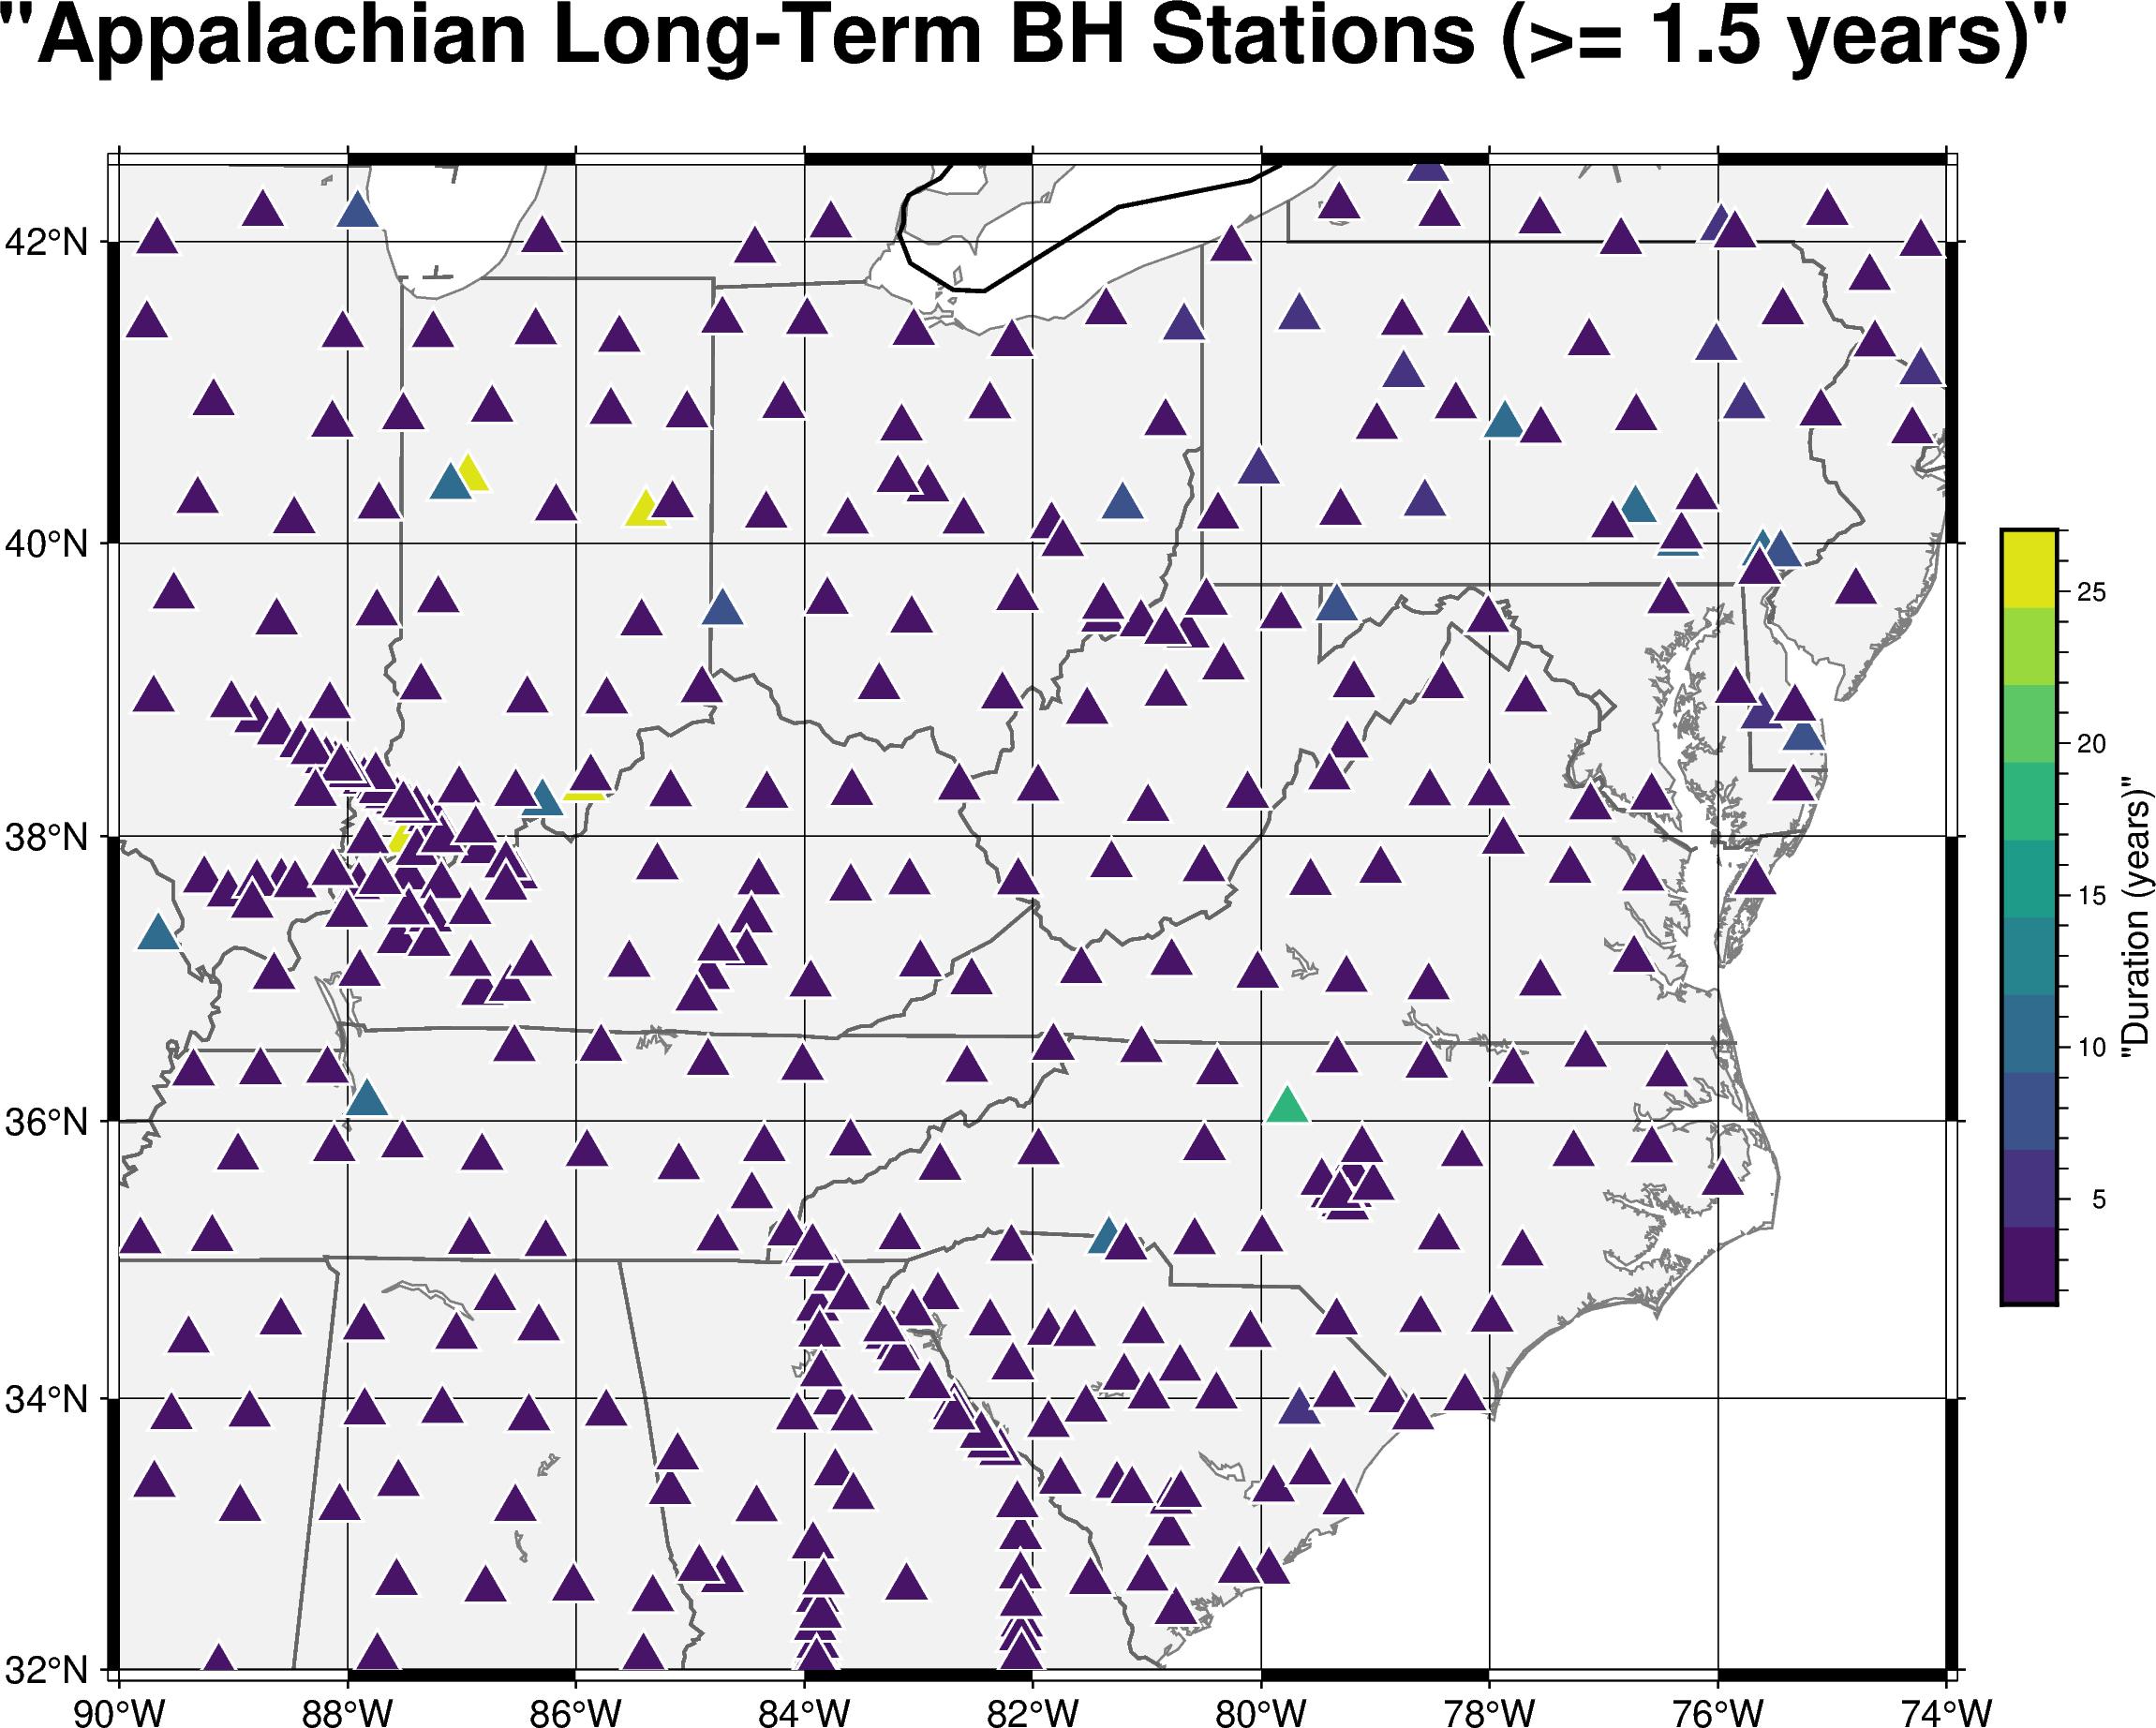

In [23]:
import pygmt
import pandas as pd

# -----------------------------
# Input station CSV
# -----------------------------
station_file = "appalachian_BH_stations_1.5yr_plus.csv"
df = pd.read_csv(station_file)

# -----------------------------
# Appalachian region
# -----------------------------
region = [-90.0, -74.0, 32, 42.5]
projection = "M6.5i"

# -----------------------------
# Create figure
# -----------------------------
fig = pygmt.Figure()

# -----------------------------
# Basemap
# -----------------------------
fig.coast(
    region=region,
    projection=projection,
    land="gray95",
    water="white",
    borders=[
        "1/1p,black",
        "2/0.8p,gray40"
    ],
    shorelines="0.5p,gray50",
    frame=["ag", 'WSne+t"Appalachian Long-Term BH Stations (>= 1.5 years)"']
)

# -----------------------------
# Symbol size (fixed for clarity)
# -----------------------------
sizes = 0.5  # fixed size in cm

# -----------------------------
# Create CPT (colormap) for duration
# -----------------------------
vmin = df["duration_years"].min()
vmax = df["duration_years"].max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax, (vmax-vmin)/10])

# -----------------------------
# Plot stations as triangles with color = duration
# -----------------------------
fig.plot(
    x=df["longitude"],
    y=df["latitude"],
    style=f"t{sizes}c",
    fill=df["duration_years"],
    cmap=True,       # use the CPT we just created
    pen="0.6p,white"
)

# -----------------------------
# Add colorbar
# -----------------------------
fig.colorbar(frame='af+l"Duration (years)"', position="JMR+o0.5c/0c+w7c/0.5c")

# -----------------------------
# Save output
# -----------------------------
fig.savefig("appalachian_longterm_1.5yr_BH_stations_triangles_colored.png", dpi=300)
fig.show()
